In [ ]:
import pandas as pd
import numpy as np
import duckdb
from fila_estacoes_utils import P_1
from tqdm.notebook import tqdm
ouro_conn = duckdb.connect('ouro_db')
import seaborn as sns
import matplotlib.pyplot as plt
from kneed import KneeLocator

def apply_P_to_df(fato_estacoes_base_fila_prioridade,P,D_medio=15,fator_decaimento=2):
    fato_estacoes_base_fila_prioridade = ouro_conn.execute("SELECT * FROM fato_estacoes_base_fila_prioridade").fetch_df()
    fato_estacoes_base_fila_prioridade["P"] = P(
        correlacao=fato_estacoes_base_fila_prioridade["correlacao"].values,
        pct_intersecao=(fato_estacoes_base_fila_prioridade["pct_intersecao_precipitacao"]/100).values,
        distancia_km=fato_estacoes_base_fila_prioridade["vl_distancia_km"].values,
        D_medio=D_medio,
        fator_decaimento=fator_decaimento
    )
    return fato_estacoes_base_fila_prioridade["P"]


# Testando diferentes parâmetros

In [2]:
D_medio_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100]
fator_decaimento_values = [1, 2, 3, 4, 5]
n_casas_decimais = 4


df_base = ouro_conn.execute("SELECT * FROM fato_estacoes_base_fila_prioridade").fetch_df()

results_max_mean = []
results = []

for D_medio in tqdm(D_medio_values, desc="Testando D_medio"):
    for fator_decaimento in fator_decaimento_values:

        df = df_base.copy()
        df["P_1"] = apply_P_to_df(df_base,P_1,D_medio,fator_decaimento).round(n_casas_decimais)

        grouped = df.groupby("id_estacao_base", as_index=False)["P_1"].max()
        P_max_mean = grouped["P_1"].mean()

        results_max_mean.append({
            "D": D_medio,
            "α": fator_decaimento,
            "P_max_mean": P_max_mean
        })
        results.append({
            "D":D_medio,
            "α":fator_decaimento,
            "results_df":df
        })

df_resultados_max_mean = pd.DataFrame(results_max_mean)

Testando D_medio:   0%|          | 0/12 [00:00<?, ?it/s]

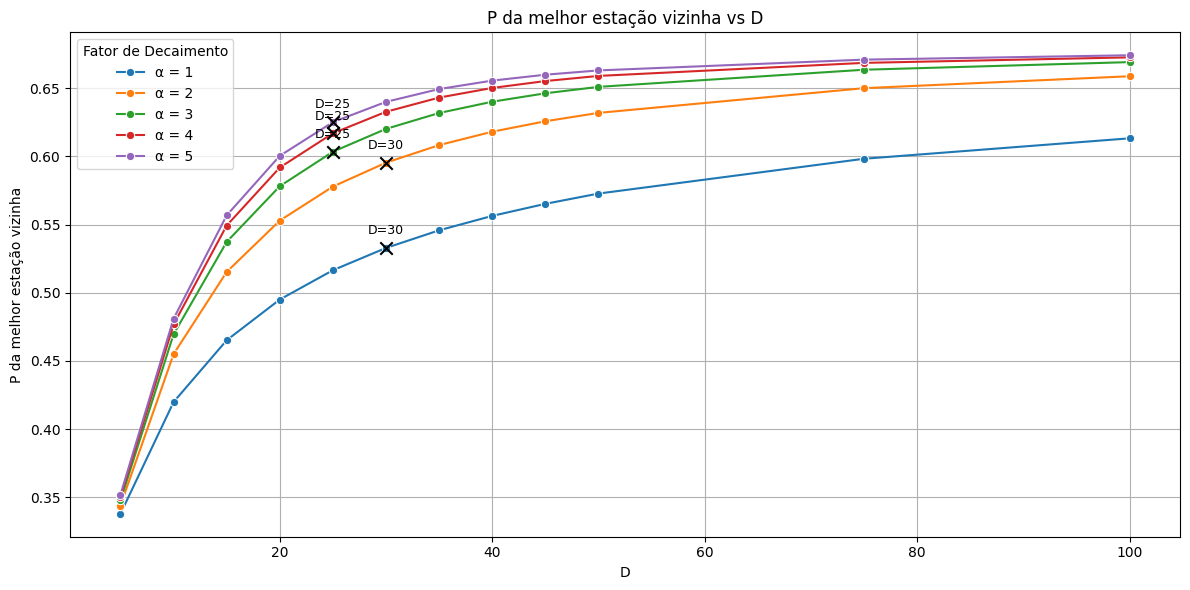

In [3]:
plt.figure(figsize=(12, 6))

cotovelos = []

# Itera sobre cada fator_decaimento
for fator in sorted(df_resultados_max_mean["α"].unique()):
    subset = df_resultados_max_mean.loc[df_resultados_max_mean["α"] == fator].sort_values("D")
    x = subset["D"].values
    y = subset["P_max_mean"].values

    knee = KneeLocator(x, y, curve="concave", direction="increasing")

    # Plota a linha
    sns.lineplot(x=x, y=y, label=f"α = {fator}", marker="o")

    # Marca e anota o cotovelo, se encontrado
    if knee.knee:
        plt.scatter(knee.knee, knee.knee_y, color='black', s=80, zorder=5,marker='x')
        plt.text(
            knee.knee, knee.knee_y + 0.01,  # deslocamento vertical
            f"D={knee.knee}", fontsize=9, color='black', ha='center'
        )

        cotovelos.append({
            "fator_decaimento": fator,
            "D_medio_ideal": knee.knee,
            "P_max_mean_no_cotovelo": knee.knee_y
        })

# Embelezamento do gráfico
plt.title("P da melhor estação vizinha vs D")
plt.xlabel("D")
plt.ylabel("P da melhor estação vizinha")
plt.grid(True)
plt.legend(title="Fator de Decaimento")
plt.tight_layout()
plt.show()

# Para qualquer fator de decaimento, D parece ser ótimo entre 25 e 30
# Alfa maior que 3 não faz grande coisa mais do que o 3.


In [5]:
D = 30
α = 3
result = [result for result in results if result['D']==D and result['α']==α][0]['results_df']

result.loc[ \
    result['P_1']<0.5
].sort_values('P_1',ascending=False).iloc[:20]

,id_estacao_base,id_estacao_candidata,correlacao,pct_intersecao_precipitacao,vl_distancia_km,P_1
6213183,574439,576038,0.580649,100.000000,16.34,0.4999
6454538,577666,577298,0.536094,100.000000,12.50,0.4999
3139856,575968,576568,0.633540,79.970501,7.15,0.4999
6041214,576580,578258,0.518087,100.000000,9.95,0.4999
3140591,575968,578007,0.636696,99.262537,19.25,0.4999
6158490,576689,32107,0.581783,96.838376,15.08,0.4999
5486492,576877,574523,0.722429,99.580654,22.80,0.4999
4857187,578068,575415,0.510431,98.805673,6.20,0.4999
1572950,496746,574594,0.620109,81.036610,5.22,0.4999
6885128,576127,574906,0.507815,99.433776,6.46,0.4999


# Analisando uma combinação específica

In [ ]:
D = 30
α = 3
n_casas_decimais = 4

df_base = ouro_conn.execute("SELECT * FROM fato_estacoes_base_fila_prioridade").fetch_df()
df_base["P_1"] = apply_P_to_df(df_base,P_1,D,α).round(n_casas_decimais)

idx_max = df_base.groupby('id_estacao_base')['P_1'].idxmax()
df_resultado = df_base.loc[idx_max].reset_index(drop=True)

dim_estacoes = ouro_conn.execute('select * from dim_estacoes').fetch_df()
estacoes_P_1_latlon = df_resultado[['id_estacao_base','P_1']].rename(columns={'id_estacao_base':'id_estacao'}).merge(dim_estacoes[['id_estacao','latitude','longitude']]).drop_duplicates()

In [77]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

def plot_estacoes_com_bins(df, lat_min=-34, lat_max=6, lon_min=-74, lon_max=-34, bins=5):
    """
    Plota estações com P_1 categorizado em cores discretas (azul → baixo, vermelho → alto).
    """
    proj = ccrs.PlateCarree()

    # Binning de P_1 em categorias
    df['P_1_cat'] = pd.cut(df['P_1'], bins=bins)

    # Cores diferentes por categoria (RdBu: azul = baixo, vermelho = alto)
    categories = df['P_1_cat'].cat.categories
    cmap = plt.get_cmap('RdBu', len(categories))  # sem o "_r" → azul = baixo, vermelho = alto

    fig, ax = plt.subplots(figsize=(128, 64), subplot_kw={'projection': proj})
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)

    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.3, edgecolor='gray')
    ax.add_feature(cfeature.LAND, facecolor='whitesmoke')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    # Plot por categoria
    for i, cat in enumerate(categories):
        subset = df[df['P_1_cat'] == cat]
        ax.scatter(
            subset['longitude'], subset['latitude'],
            color=cmap(i), label=str(cat), s=200, edgecolor='none', transform=proj
        )

    ax.legend(title='P_1 (faixas)', loc='lower left')
    ax.set_title('Maior P encontrado para cada estação', fontsize=64)
    plt.show()


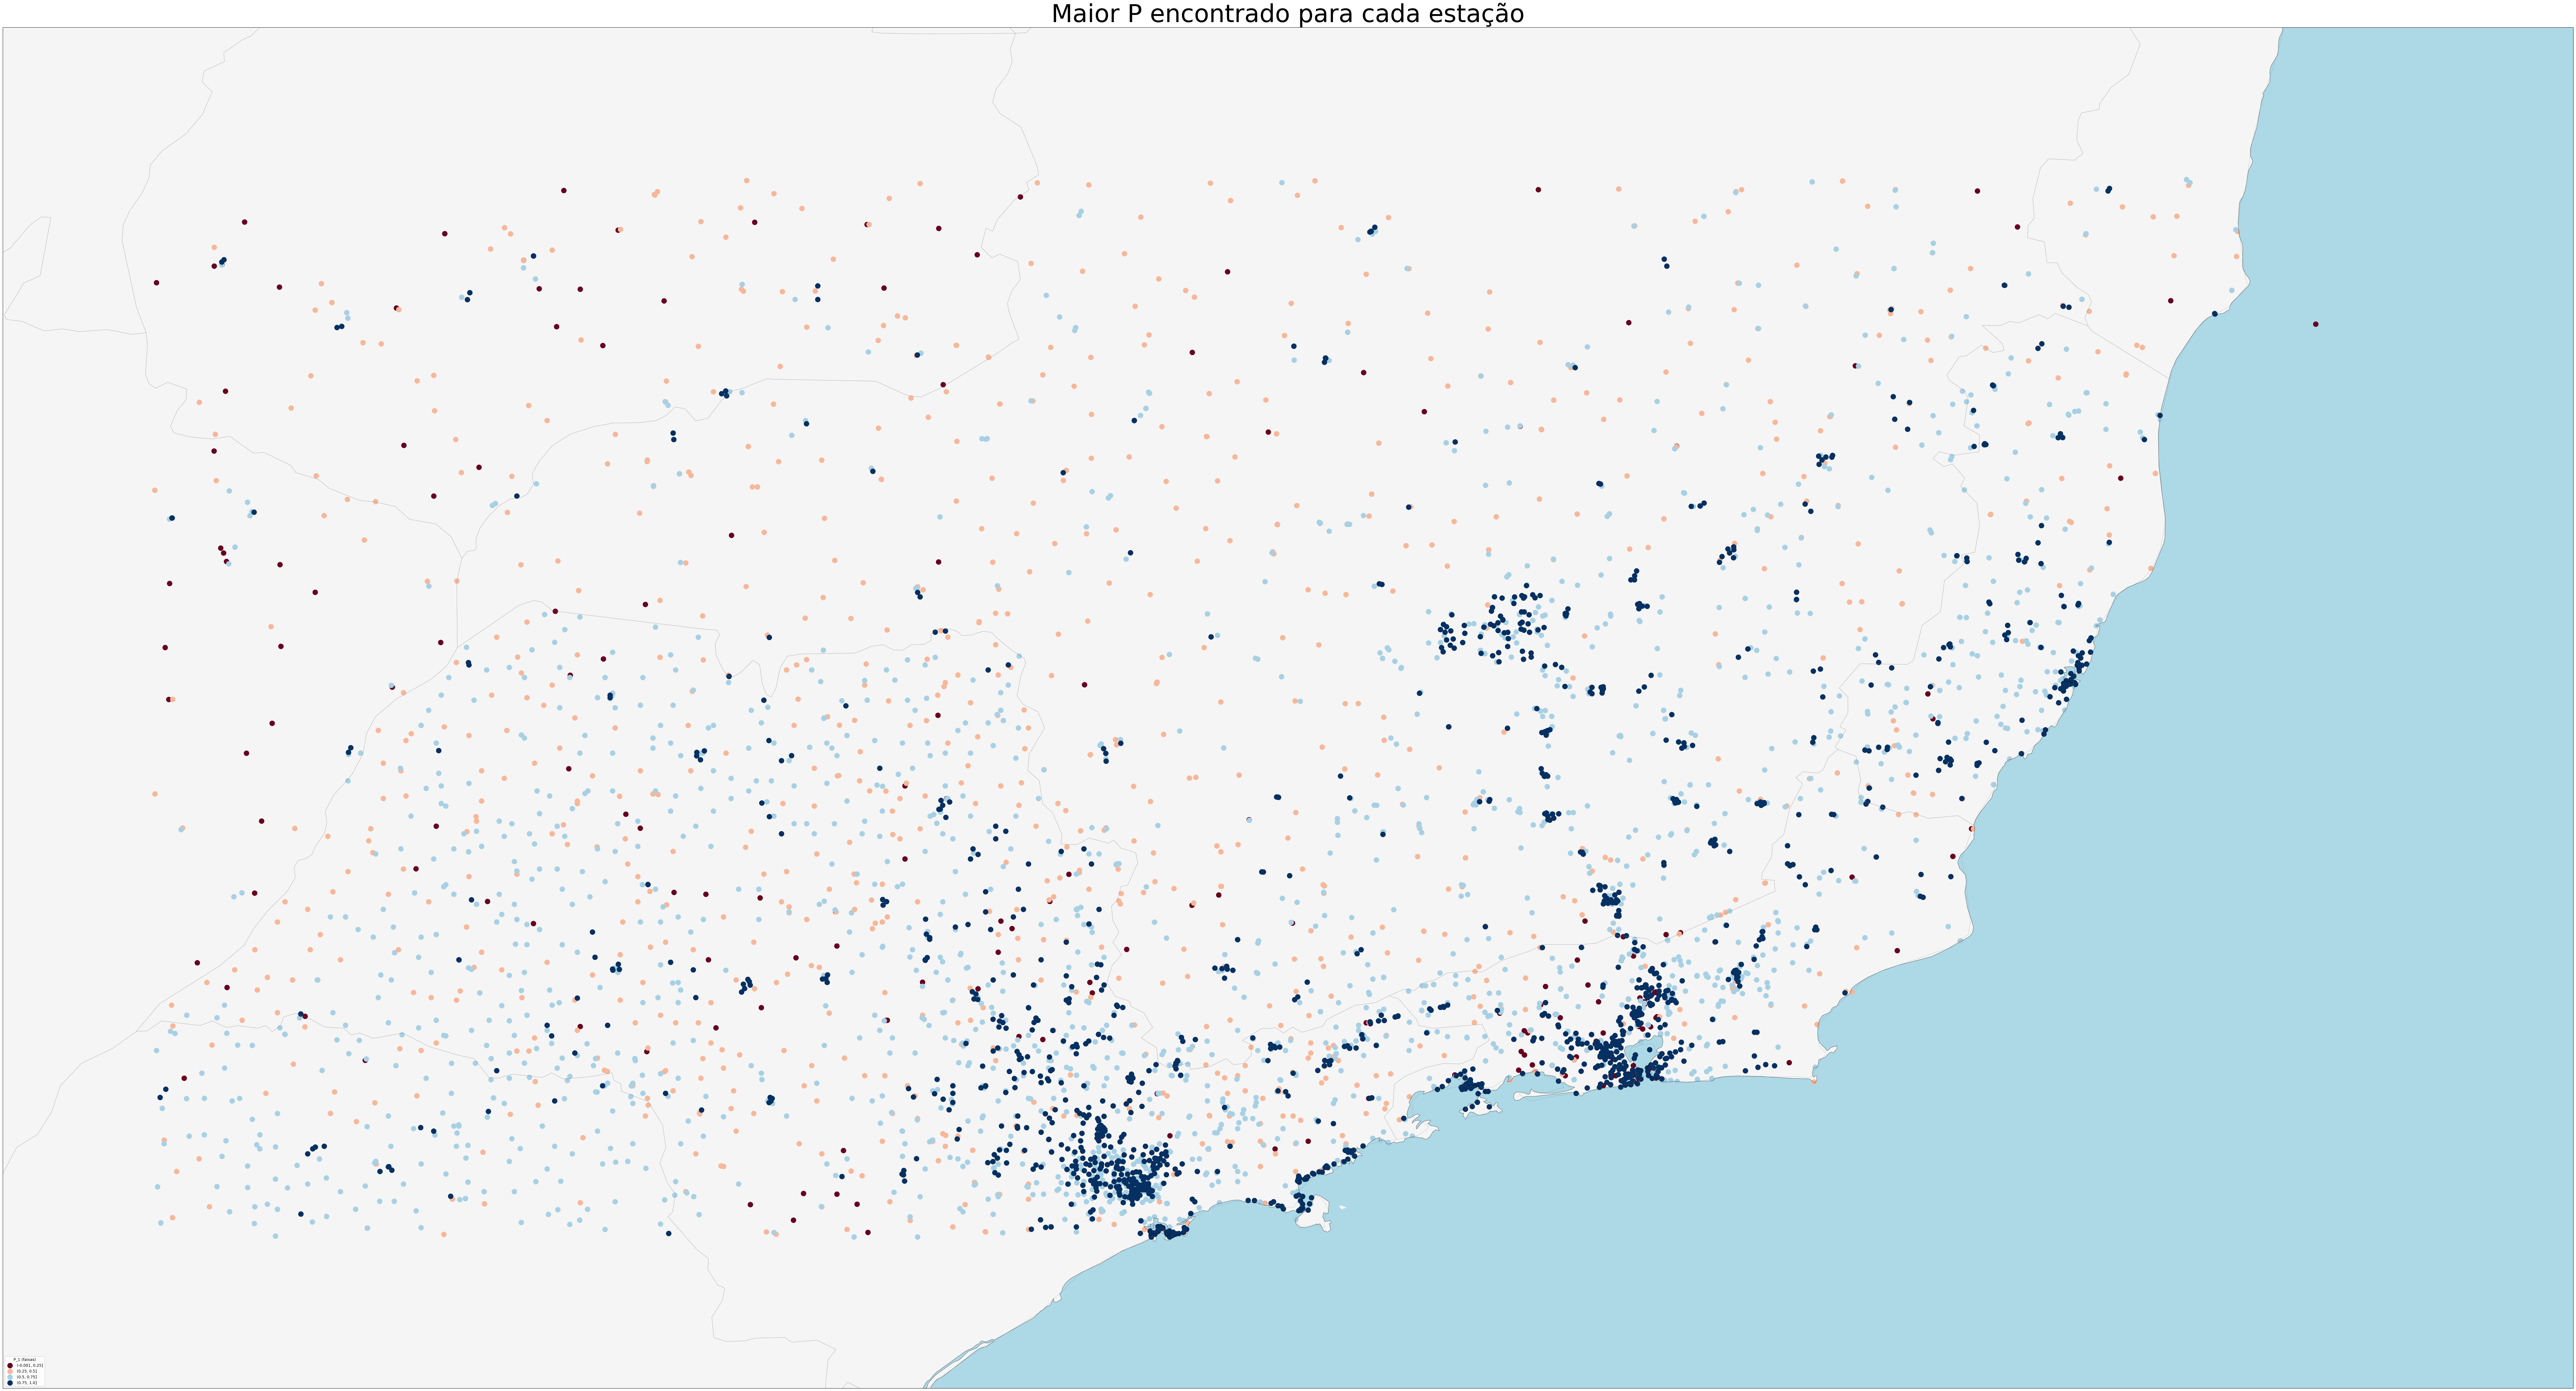

In [78]:
plot_estacoes_com_bins(estacoes_P_1_latlon, lat_min=-25, lat_max=-16, lon_min=-54, lon_max=-37,bins=4)

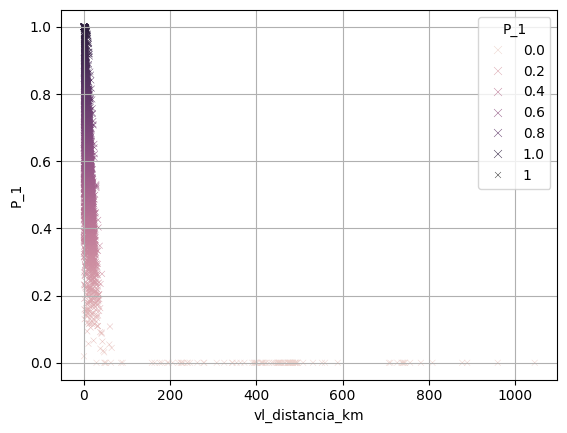

In [31]:
sns.scatterplot(df_resultado,y='P_1',x='vl_distancia_km',hue='P_1',size=1,marker='x')
plt.grid()